In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from cartesian_explorer import Explorer
import cartesian_explorer as caex

import qtensor
import pickle
import miplog_helper

2021-11-23 20:17:17,666- WARNING•	QuickBB solver is unavailable


twl /home/dlykov/anl/Qensor/qtree/thirdparty/tamaki_treewidth/tw-exact


In [2]:
from datetime import datetime, timedelta
from functools import wraps

class throttle():
    """ Decorator class that limits number of calls for function"""
    def __init__(self, per_sec=20, max_calls=1, warmup=0):
        self.period = timedelta(microseconds=1000000/per_sec)
        self.t0 = datetime.min
        self.max_calls = max_calls
        self.calls_done = 0
        self.warmup = timedelta(seconds=warmup)
        self.warmup_expired = False

    def __call__(self, fn):
        @wraps(fn)
        def wrapper(*args, **kwargs):
            t1 = datetime.now()
            if self.t0 == datetime.min:
                self.t0 = t1
            dt = t1 - self.t0
            secs2wait = (self.period - dt).total_seconds()
            if self.warmup_expired:
                if secs2wait > 0:
                    if self.calls_done==self.max_calls:
                        return 
                    else:
                        self.calls_done += 1
                else:
                    self.calls_done = 1
                    self.t0 = datetime.now()
            else:
                self.warmup_expired = self.warmup < dt

            return fn(*args, **kwargs)

        return wrapper

In [3]:
import networkx as nx
from typing import Tuple
import gurobipy as gb
import time

def maxcut_bounds_history(G: nx.Graph,
                          max_time=10*60,
                          max_cost=None,
                          threads=None,
                          verbose=True,
                          callback=None,
                          gurobi_options={}
                         ) -> Tuple[list, list]:
    p = gb.Model()
    p.setParam('TimeLimit', max_time)
    if max_cost is not None:
        p.setParam('BestObjStop', max_cost)
    if threads is not None:
        p.setParam('Threads', threads)
    if verbose is False:
        p.setParam('OutputFlag', 0)
    for key in gurobi_options:
        p.setParam(key, gurobi_options[key])
        
    vdict = {}
    for n in G.nodes:
        vdict[n] = p.addVar(name='v_'+str(n), vtype=gb.GRB.BINARY)
    scaled_v = {v:(2*x - 1) for v, x in vdict.items()}
    C_i = [vdict[i] + vdict[j] - 2*vdict[i]*vdict[j] for i, j in G.edges]
    
    p.setObjective(sum(C_i), gb.GRB.MAXIMIZE)
    
    startop = time.time()
    upper = []
    lower = []
    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        return None
        
    miplog = []
    start = time.time()

    @throttle(per_sec=1, warmup=1)
    @throttle(per_sec=100)
    def on_update(model, where, cost, bound):
        nonlocal start
        if start == 0:
            start = time.time()
        dt = time.time()-start
        miplog.append([dt, bound, cost])
        print(f'[{dt}]', 'MIP', 'cost=', cost, 'bound=', bound)

    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        cst = 0
        if where == gb.CallbackClass.MIP:
            cst = model.cbGet(gb.CallbackClass.MIP_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIP_OBJBND)
        if where == gb.CallbackClass.MIPSOL:
            cst = model.cbGet(gb.CallbackClass.MIPSOL_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIPSOL_OBJBND)
        if cst>0:
            on_update(model, where, cst, bnd)
        
    if callback is None:
        callback = clb
        
    p.optimize(callback=callback)
    miplog.append(
        [time.time()-startop, p.ObjBound, p.ObjVal]
    )
        
    return miplog


In [4]:
GUROBI_THREADS = 1 #set to 0 to use all available

In [5]:
N = 256
seed = 32
degree = 3
graph = qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=degree)

In [144]:
max_time = 600
gurobi_options = {'Symmetry': 0, 'PreQLinearize': 2}
    
miplog = maxcut_bounds_history(
    graph, max_time=max_time, threads=GUROBI_THREADS,
    gurobi_options=gurobi_options
)


Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter Threads to 1
   Prev: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter Symmetry to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter PreQLinearize to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 56 physical cores, 112 logical processors, using up to 1 threads
Optimize a model with 0 rows, 256 columns and 0 nonzeros
Model fingerprint: 0x15885010
Model has 384 quadratic objective terms
Variable types: 0 continuous, 256 integer (256 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 205 rows, 461 columns, 794 nonzeros
Variable types: 0 continuou

[23.234555959701538] MIP cost= 349.0 bound= 362.0
[24.235552310943604] MIP cost= 349.0 bound= 361.0
  3773  1953  357.45104   20  303  349.00000  361.80841  3.67%   128   25s
[25.271713495254517] MIP cost= 349.0 bound= 361.0
[26.27504563331604] MIP cost= 349.0 bound= 361.0
[27.290937900543213] MIP cost= 349.0 bound= 361.0
[28.30145239830017] MIP cost= 349.0 bound= 361.0
* 4229  2184              39     349.9999982  361.52443  3.29%   131   28s
H 4230  2062                     350.0000000  361.52443  3.29%   131   28s
[29.30829381942749] MIP cost= 350.0 bound= 361.0
  4369  2089  356.71614   20  303  350.00000  361.43473  3.27%   132   30s
[30.318315744400024] MIP cost= 350.0 bound= 361.0
[31.32566809654236] MIP cost= 350.0 bound= 361.0
[32.3303279876709] MIP cost= 350.0 bound= 361.0
[33.33654832839966] MIP cost= 350.0 bound= 361.0
[34.338510036468506] MIP cost= 350.0 bound= 361.0
  4921  2319  352.95563   24  281  350.00000  361.22428  3.21%   137   35s
[35.34394884109497] MIP cost= 35

[152.52137207984924] MIP cost= 351.0 bound= 355.0
[153.54988646507263] MIP cost= 351.0 bound= 355.0
[154.55115032196045] MIP cost= 351.0 bound= 355.0
 16126  3065  352.88261   30  307  351.00000  355.79545  1.37%   172  155s
[155.5553183555603] MIP cost= 351.0 bound= 355.0
[156.55881452560425] MIP cost= 351.0 bound= 355.0
[157.56671690940857] MIP cost= 351.0 bound= 355.0
[158.5710768699646] MIP cost= 351.0 bound= 355.0
[159.57181477546692] MIP cost= 351.0 bound= 355.0
 16546  2948  353.23746   33  281  351.00000  355.65942  1.33%   174  160s
[160.58314657211304] MIP cost= 351.0 bound= 355.0
[161.5981080532074] MIP cost= 351.0 bound= 355.0
[162.59941029548645] MIP cost= 351.0 bound= 355.0
[163.60543060302734] MIP cost= 351.0 bound= 355.0
[164.61036729812622] MIP cost= 351.0 bound= 355.0
 16995  2814     cutoff   31       351.00000  355.55683  1.30%   175  165s
[165.6217405796051] MIP cost= 351.0 bound= 355.0
[166.62420058250427] MIP cost= 351.0 bound= 355.0
[167.63403296470642] MIP cost

  Gomory: 31
  MIR: 129
  StrongCG: 16
  Flow cover: 153
  Zero half: 124
  RLT: 57
  Relax-and-lift: 2

Explored 27890 nodes (5224545 simplex iterations) in 279.96 seconds
Thread count was 1 (of 112 available processors)

Solution count 10: 351 350 349 ... -0

Optimal solution found (tolerance 1.00e-04)
Best objective 3.510000000000e+02, best bound 3.510000000000e+02, gap 0.0000%

User-callback calls 110122, time in user-callback 0.65 sec


In [145]:
dh = miplog_helper.MiplogData(miplog)
diffs = dh.get_diff_data()
start = dh.get_starting_point()
gurobi_hist =  [start] + diffs

In [146]:
miplog

[[0.013442754745483398, 384.0, 285.0],
 [0.014133214950561523, 384.0, 343.0],
 [0.017055273056030273, 384.0, 343.0],
 [0.025676250457763672, 382.0, 343.0],
 [0.03582763671875, 379.0, 343.0],
 [0.04776477813720703, 379.0, 343.0],
 [0.05905747413635254, 378.0, 343.0],
 [0.06958365440368652, 378.0, 343.0],
 [0.0952310562133789, 378.0, 343.0],
 [0.1071925163269043, 378.0, 343.0],
 [0.11870408058166504, 377.0, 343.0],
 [0.12880849838256836, 377.0, 343.0],
 [0.1390702724456787, 377.0, 343.0],
 [0.14911675453186035, 377.0, 343.0],
 [0.15916872024536133, 377.0, 345.0],
 [0.1710350513458252, 377.0, 345.0],
 [0.18123936653137207, 377.0, 345.0],
 [0.19242191314697266, 377.0, 345.0],
 [0.2037818431854248, 377.0, 345.0],
 [0.21686959266662598, 377.0, 347.0],
 [0.22727704048156738, 377.0, 347.0],
 [0.23918557167053223, 377.0, 347.0],
 [0.25119447708129883, 377.0, 347.0],
 [0.26140666007995605, 377.0, 347.0],
 [0.271498441696167, 377.0, 347.0],
 [0.28165674209594727, 377.0, 347.0],
 [0.29231023788452

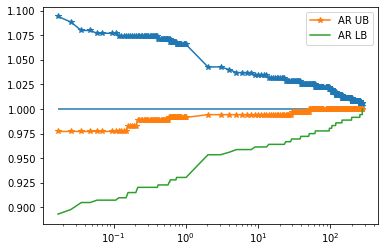

In [147]:
dh.plot()

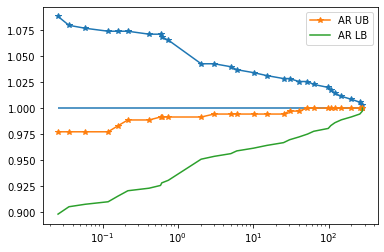

In [148]:
dh2 = miplog_helper.MiplogData.from_start_and_diffs(start, diffs)
dh2.plot()

In [149]:
pickle.dump(gurobi_hist, open(f'../gurobi_single_N{N}_s{seed}.pkl', 'wb+'))

## Multiple seeds

In [6]:
from cartesian_explorer import parallels

In [7]:
par = parallels.Ray(processes=56)

In [8]:
def unit(seed):
    N = 256
    degree = 3
    graph = qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=degree)
    max_time = 600
    gurobi_options = {'Symmetry': 0, 'PreQLinearize': 2}

    miplog = maxcut_bounds_history(
        graph, max_time=max_time, threads=GUROBI_THREADS,
        gurobi_options=gurobi_options
    )
    dh = miplog_helper.MiplogData(miplog)
    diffs = dh.get_diff_data()
    start = dh.get_starting_point()
    gurobi_hist =  [start] + diffs
    return gurobi_hist

In [9]:
%%time
seeds = range(100)
result =  par.map(unit, seeds)

CPU times: user 12.3 s, sys: 2 s, total: 14.3 s
Wall time: 15min 26s


In [10]:
pickle.dump(result, open(f'../gurobi_single_N{N}_seeds{len(seeds)}.pkl', 'wb+'))

Activate Gurobi

In [9]:
import socket
if socket.gethostname().startswith('skylake'):
    gurobi_lic = '/home/dlykov/git-build/gurobi/'
    print('getting license')
    grbkey = '78b207ae-4c94-11ec-aac7-0242ac120002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey

getting license
info  : grbgetkey version 9.1.2, build v9.1.2rc0
info  : Contacting Gurobi license server...
info  : License file for license ID 730806 was successfully retrieved
info  : License expires at the end of the day on 2022-01-21
info  : Saving license file...
info  : License 730806 written to file /home/dlykov/git-build/gurobi/gurobi.lic


---